# Cryptocurrency Market Predictor - Recurrent Neural Network

Predicting BTCUSD market

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [2]:
dataset = pd.read_csv('ETHUSD_TechnicalIndicators.csv', nrows=5000)
dataset.tail(2)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
4998,291.995,291.995,0.018774,291.99,5.799337,291.99,292.0,110.306063,27.558405,0.01
4999,291.995,291.995,0.010257,291.99,5.799337,291.99,292.0,581.240510,27.558405,0.01


In [3]:
spotdata = pd.read_csv('ETHUSD_SPOT.csv', nrows=100)
spotdata.tail(2)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
98,287.975,287.975,-0.020007,287.97,5.99,287.97,287.98,36.743216,0.145509,0.01
99,287.975,287.975,-0.020770,287.97,5.99,287.97,287.98,38.105166,0.145509,0.01


#### Normalize

In [4]:
PriceRange=dataset["Price"].max() - dataset["Price"].min()
PriceMean = dataset["Price"].mean()
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm.head(3)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
0,-0.383638,-0.359782,-0.000954,-0.989820,-0.017118,-0.397007,-0.369611,-0.060744,0.241710,0.176219
1,-0.382809,-0.359782,-0.000779,-0.989820,-0.017118,-0.398663,-0.366294,-0.013768,-0.089702,0.207469
2,-0.382809,-0.385487,-0.000779,-0.006949,-0.016206,-0.398663,-0.366294,-0.013768,-0.089702,0.207469


In [5]:
SpotPriceRange=spotdata["Price"].max() - spotdata["Price"].min()
PriceMean = spotdata["Price"].mean()
spotdataNorm = (spotdata - spotdata.mean()) / (spotdata.max() - spotdata.min())
spotdataNorm.head(3)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
0,-0.48034,-0.505867,-0.162451,-0.446736,-0.167326,-0.453786,-0.502019,0.117721,-0.192106,-0.140256
1,-0.48034,-0.505867,-0.169890,-0.446736,-0.167326,-0.453786,-0.502019,0.117847,-0.192313,-0.140256
2,-0.48034,-0.505867,-0.175720,-0.446736,-0.167352,-0.453786,-0.502019,0.117847,-0.192313,-0.140256


## Hyperparams

In [6]:
num_epochs = 100

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 10 #The size of the sequence

state_size = 25 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 1000

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 5000
The current configuration gives us 500 batches of 1 observations each one looking 10 steps in the past


## Train-Test split

In [7]:
datasetTrain = datasetNorm[dataset.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[dataset.index >= test_first_idx]

In [8]:
datasetTest = spotdataNorm

In [9]:
datasetTrain.head(2)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
0,-0.383638,-0.359782,-0.000954,-0.98982,-0.017118,-0.397007,-0.369611,-0.060744,0.241710,0.176219
1,-0.382809,-0.359782,-0.000779,-0.98982,-0.017118,-0.398663,-0.366294,-0.013768,-0.089702,0.207469


In [10]:
datasetTest.head(2)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
0,-0.48034,-0.505867,-0.162451,-0.446736,-0.167326,-0.453786,-0.502019,0.117721,-0.192106,-0.140256
1,-0.48034,-0.505867,-0.169890,-0.446736,-0.167326,-0.453786,-0.502019,0.117847,-0.192313,-0.140256


In [11]:
#Pick appropriate columns to train
xTrain = datasetTrain[['Price','b1','a1','Spread']].as_matrix()
yTrain = datasetTrain['PriceTarget'].as_matrix()

In [12]:
print(xTrain[0:3],'\n',yTrain[0:3])

[[-0.38363798 -0.39700695 -0.36961061  0.17621875]
 [-0.38280879 -0.39866258 -0.36629386  0.20746875]
 [-0.38280879 -0.39866258 -0.36629386  0.20746875]] 
 [-0.35978242 -0.35978242 -0.38548723]


In [13]:
#Pick appropriate columns to test
xTest = datasetTest[['Price','b1','a1','Spread']].as_matrix()
yTest = datasetTest['PriceTarget'].as_matrix()

In [14]:
print(xTest[0:3],'\n',yTest[0:3])

[[-0.48033981 -0.45378641 -0.50201923 -0.14025641]
 [-0.48033981 -0.45378641 -0.50201923 -0.14025641]
 [-0.48033981 -0.45378641 -0.50201923 -0.14025641]] 
 [-0.50586735 -0.50586735 -0.50586735]


## Visualize starting price data

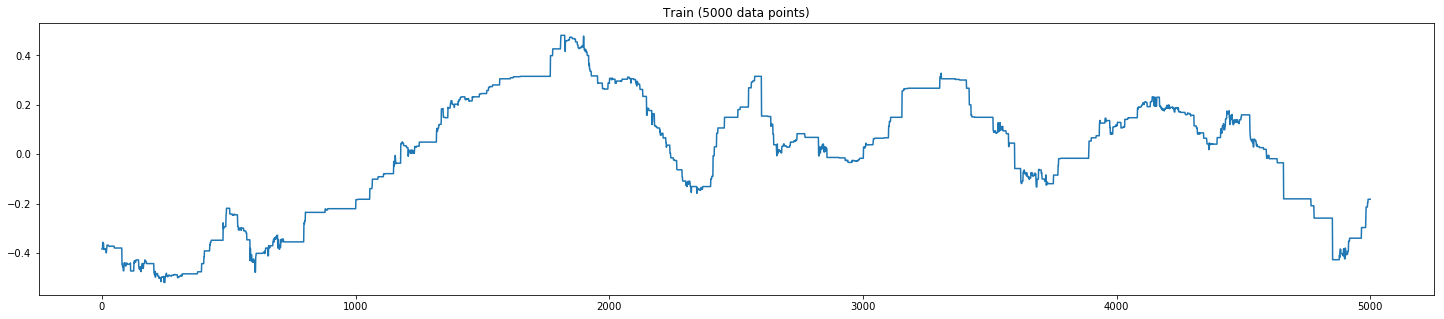

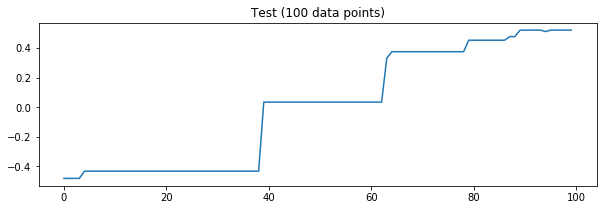

In [15]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

## Placeholders

In [16]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Weights and biases
Because is a 3 layer net:
1. Input
2. Hidden Recurrent layer
3. Output

We need 2 pairs of W and b

In [17]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Unpack

In [18]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass - Unroll the cell

Input to recurrent

In [19]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [20]:
states_series = tf.transpose(states_series,[1,0,2])

## Backward pass - Output

In [21]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

## Weights and bias out

In [22]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

## Prediction, Loss & Optimizer

In [23]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [24]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

C:\Users\Jason\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [25]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 200 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 22.542545
Step 200 - Loss: 0.000070
Step 400 - Loss: 0.004863
Epoch 1
Step 0 - Loss: 0.004379
Step 200 - Loss: 0.000772
Step 400 - Loss: 0.000269
Epoch 2
Step 0 - Loss: 0.001307
Step 200 - Loss: 0.001045
Step 400 - Loss: 0.000169
Epoch 3
Step 0 - Loss: 0.006100
Step 200 - Loss: 0.000718
Step 400 - Loss: 0.000023
Epoch 4
Step 0 - Loss: 0.011896
Step 200 - Loss: 0.000498
Step 400 - Loss: 0.000049
Epoch 5
Step 0 - Loss: 0.017954
Step 200 - Loss: 0.000545
Step 400 - Loss: 0.000217
Epoch 6
Step 0 - Loss: 0.015456
Step 200 - Loss: 0.000276
Step 400 - Loss: 0.001819
Epoch 7
Step 0 - Loss: 0.005533
Step 200 - Loss: 0.000217
Step 400 - Loss: 0.001705
Epoch 8
Step 0 - Loss: 0.004249
Step 200 - Loss: 0.000321
Step 400 - Loss: 0.001642
Epoch 9
Step 0 - Loss: 0.005267
Step 200 - Loss: 0.000369
Step 400 - Loss: 0.001830
Epoch 10
Step 0 - Loss: 0.007718
Step 200 - Loss: 0.000375
Step 400 - Loss: 0.002029
Epoch 11
Step 0 - Loss: 0.008548
Step 200 - Loss: 0.000446
Step 400 - Loss

Step 400 - Loss: 0.000031
Epoch 97
Step 0 - Loss: 0.000121
Step 200 - Loss: 0.000344
Step 400 - Loss: 0.000031
Epoch 98
Step 0 - Loss: 0.000043
Step 200 - Loss: 0.000225
Step 400 - Loss: 0.000040
Epoch 99
Step 0 - Loss: 0.000217
Step 200 - Loss: 0.000511
Step 400 - Loss: 0.000032


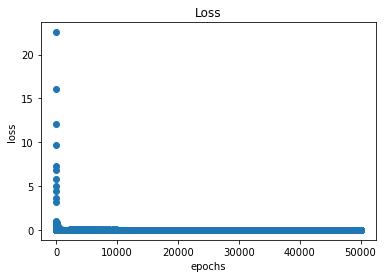

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)),y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

#### Denormalize

In [27]:
test_pred_list[:] = [(x*PriceRange)+PriceMean for x in test_pred_list]
yTest[:] = [(x*PriceRange)+PriceMean for x in yTest]

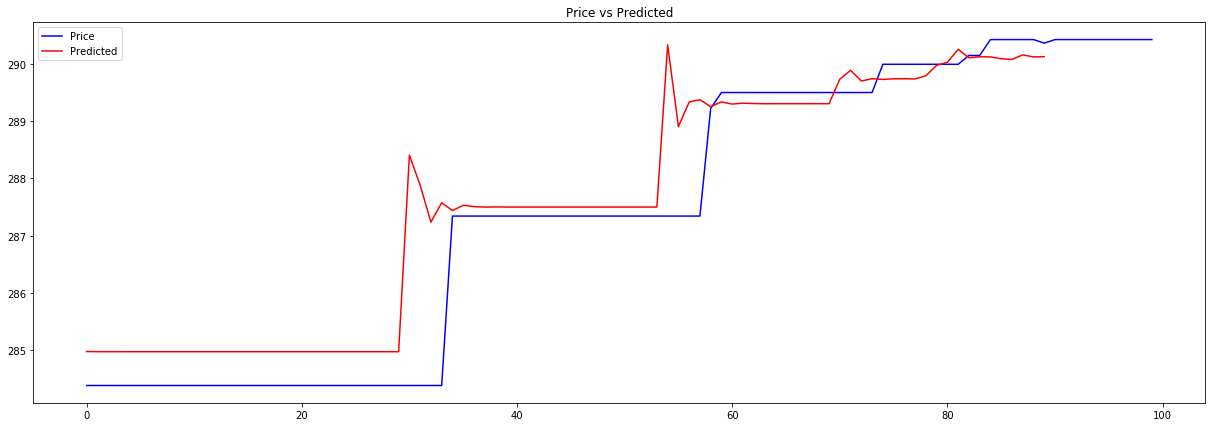

In [28]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()

In [29]:
len(test_pred_list)

90

In [30]:
predict= pd.DataFrame(test_pred_list, columns=['Prediction'])

In [31]:
real = pd.DataFrame(yTest, columns=['Price'])

In [32]:
realVSpredict = predict.join(real)

In [33]:
realVSpredict

,Prediction,Price
0,284.981353,284.389370
1,284.979045,284.389370
2,284.978418,284.389370
3,284.978517,284.389370
4,284.978336,284.389370
5,284.978336,284.389370
6,284.978336,284.389370
7,284.978336,284.389370
8,284.978336,284.389370
9,284.978336,284.389370
